# VGG16 フィルタ画像の作成

ImageNet で学習済みの VGG-16 の畳み込み層とプーリング層に存在する全てのフィルタそれぞれに対して最も反応する画像を生成する。

In [1]:
from keras.applications import VGG16
from keras import backend as K
import numpy as np
import math, cv2

model = VGG16(weights="imagenet", include_top=False)

def _deprocess_image(x):
  # テンソルを正規化: 中心 0、標準偏差 0.1 に調整
  x -= x.mean()
  x /= (x.std() + 1e-5)
  x *= 0.1

  # [0,1] 範囲にクリッピング
  x += 0.5
  x = np.clip(x, 0, 1)

  # RGB に変換
  x *= 255
  x = np.clip(x, 0, 255).astype(np.uint8)
    
  # RGBA に変換
  alpha = np.full((x.shape[0], x.shape[1], 1), 255)
  return np.concatenate((x, alpha), axis=2).astype(np.uint8)

def generate_pattern(layer_name, filter_index, size=150):
  layer_output = model.get_layer(layer_name).output
  loss = K.mean(layer_output[:, :, :, filter_index])
  grads = K.gradients(loss, model.input)[0]
  grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
  iter = K.function([model.input], [loss, grads])
  input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.
  step = 1.
  for i in range(40):
    loss_value, grads_value = iter([input_img_data])
    input_img_data += grads_value * step
  img = input_img_data[0]
  return _deprocess_image(img)

def concat_images(images, spacing=1):
  n_images = len(images)
  rows = math.ceil(math.sqrt(n_images))
  cols = math.ceil(n_images / rows)
  vstack = []
  for y in range(cols):
    size = min(rows, n_images - y * cols)
    hstack = []
    for x in range(rows):
      if x is not 0:
        hstack.append(np.zeros((images[x-1].shape[0], spacing, 4), dtype=np.uint8))
      i = y * cols + x
      if i < len(images):
        hstack.append(images[i].astype(np.uint8))
      else:
        hstack.append(np.zeros(images[0].shape, dtype=np.uint8))
    row = cv2.hconcat(hstack)
    vstack.append(row)
    if y + 1 < cols:
      vstack.append(np.zeros((spacing, row.shape[1], 4), dtype=np.uint8))
  array = cv2.vconcat(vstack)
  return Image.fromarray(array, "RGBA")


Using TensorFlow backend.


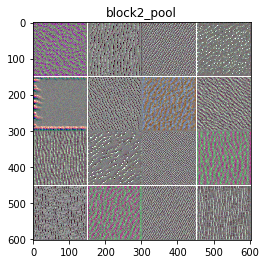

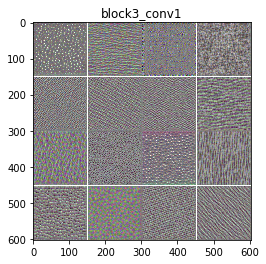

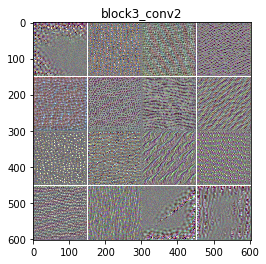

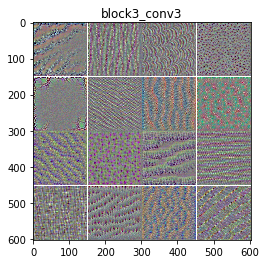

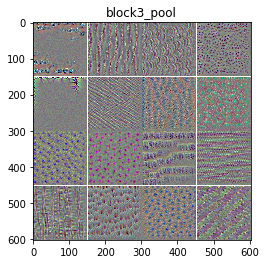

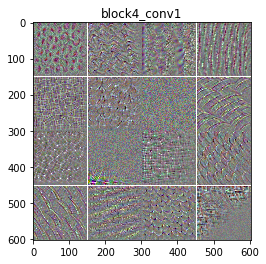

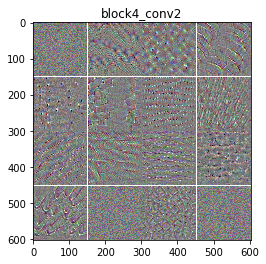

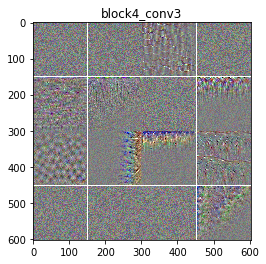

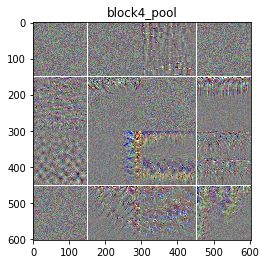

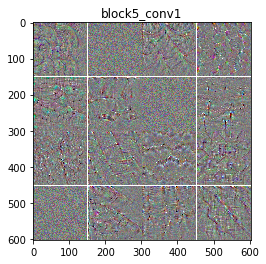

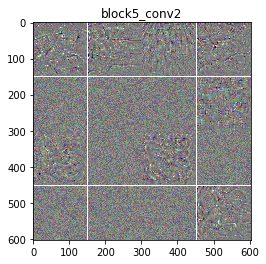

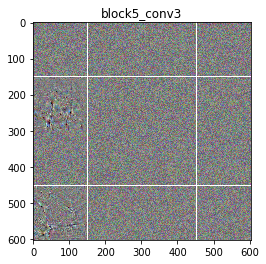

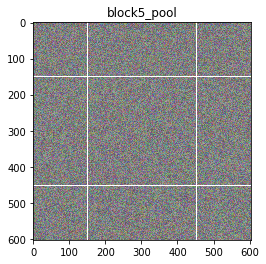

In [2]:
import matplotlib.pyplot as plt
from PIL import Image
import os
%matplotlib inline

output_dir = "vgg16-filters"
frames = 5

if not os.path.isdir(output_dir):
  os.makedirs(output_dir)

for layer in model.layers:
  file = os.path.join(output_dir, "%s.gif" % layer.name)
  if not os.path.isfile(file):
    length = min(16, int(layer.output.shape[3]))
    images = []
    for j in range(frames):
      filters = []
      for i in range(length):
        size = min(150, int(1024 / math.sqrt(length)))
        # print("%s[%d/%d] %spx" % (layer.name, i, length, size))
        img = generate_pattern(layer.name, i, size)
        filters.append(img)
      images.append(concat_images(filters))
    images[0].save(file, save_all=True, append_images=images[1:], optimize=False, duration=400, loop=0, transparency=0)
    plt.title("%s" % layer.name)
    plt.imshow(images[0])
    plt.show()